# Reach-Scale Modeling Analysis

This Notebook covers preliminary analysis for the design of a simple reach-scale model in TempEst-NEWT/NEXT.

The reach model aims to be as simple as possible while achieving two goals with reasonable accuracy:

- General goal: allow efficient estimation of reach temperature profiles, particularly downstream of observation points or disturbances such as reservoirs.  (Thus, it must be possible to provide arbitrary upstream data, not just a NEWT model.)
- Specific goal: account for key in-channel fluxes such as solar radiation (riparian shading), evaporation, and general atmospheric heat exchange, which cannot be accounted for by a lumped watershed model.  This allows model users to analyze key reach-scale phenomena.

It is anticipated that this can be achieved with a simple equilibrium model, where (for water temperature $T$ and air temperature $T_a$ in C, time $t$, and fitting coefficients $A,~B$):

$$
    \frac{dT}{dt} = A(T_a-T) + B
$$

The fitting coefficient $A$ lumps together a variety of influences on sensible heat flux, such as channel depth.  The fitting coefficient $B$ parametrizes a number of effects where their variation with stream temperature probably cannot be estimated for an ungaged watershed, and which are therefore assumed to be constant (with respect to temperature, not time).  These include, chiefly, solar radiation, evaporation, and lateral/groundwater inflows.

For model training purposes, we do not have densely-spaced observations, and it is necessary to apply uniform coefficients.  Over long distances, applying the above equation linearly would result in substantial error, so we use an exponential solution:

$$
    T - T_a = C\exp(-At) + Bt \implies T = C\exp(-At) + Bt + T_a \implies \Delta T = T_0-T = (C + T_a) - (C\exp(-At) + Bt + T_a) = C(1-\exp(-At)) - Bt
$$

Such that:

- If $B$ is zero, $T$ exponentially decays towards $T_a$
- C = $T-T_a$ at the initial step
- A and B are fitted

A further necessity is to estimate the travel time over a reach, $t$.  With uniform flow, we can begin from Manning's equation, $v=\frac1n R^{2/3}S^{1/2}$ (for velocity $v$, roughness $n$, hydraulic radius $R$, and slope $S$).  Assuming - somewhat dubiously, but of necessity without coupling a hydrologic model - that $R$ has a power-law relationship to flow $Q$, which in turn has a power law relationship to the product of drainage area $D$ and precipitation $P$, we have $v=\frac1{\alpha}\frac1n(DP)^{\beta}S^{1/2}$ for fitting coefficients $\alpha,~\beta$.  Thus, for reach length $L$ and fitting coefficient 

$$
    t = \frac{\alpha Ln}{(DP)^{\beta}\sqrt{S}}
$$

Now, for the CONUS, we can get $n$, $L$, $S$ from NHDPlus Value Added Attributes, and only need to estimate $\alpha,~\beta$.

Note that for fitting a single river, those are all constant, so we (introducing a few more fitting coefficients, because we don't have enough to keep track of) simply have $t=\frac{k}{(DP)^q}$, and therefore need to fit $A,~B,~k,~q$ (we have an analytic solution for $C$).  Fitting four coefficients is pretty easy with a reasonably long timeseries, and since we're using a simple analytic solution, we can very quickly calculate tons of permutations and identify a rock-solid optimum.  If our assumptions are sufficiently decent, of course.

Now, how do we get the training data?  We want to use the reach model to capture details that the lumped model can't, so we're going to train off of USGS observations, which is why we can't get high-resolution training data.  But we do want our training data to represent a range of reach lengths, so we don't miss long-range or short-range effects.  So, over the 900ish development gages, we:

1. Set a random reach length as an integer kilometer between 1-100 km, uniformly distributed on a log scale (i.e., 1, 10, 100 not 1, 50, 100).  Longer than 100 km is past what would likely be of interest, and far too long to be anything like uniform; shorter than 1 km is getting into the range where detailed hydrology and hydraulics inaccessible to NEXT would be important.  Note that it'll be necessary to check the actual mainstem length, since some sites may have less than 100 km upstream.  I am going to arbitrarily set the maximum length to be 10% of the mainstem, so that most flow comes from the upper watershed; otherwise our Q~AP assumption would be even more problematic.
2. Compute flow time in the reach.
3. Compute the "no-reach" temperature as the area-weighted mean of all contributing watershed temperatures, with the timestep offset if flow time is more than half a day.
4. Compute the "missing" temperature as the difference between observed and no-reach temperature.
5. Using the first 70% of the available timeseries, calibrate the reach model coefficients to the "missing" temperature.
6. Test that solution on the final 30%.
7. Develop coefficient estimation.

Using what we've derived above, the final solution for reachwise *change in temperature* is:

$$
    \Delta T =  (T_0-T_a)\left(1-\exp\left(-\frac{Ak}{(DP)^q}\right)\right) - \frac{Bk}{(DP)^q}
$$

Note that $k$, $q$ are constants, while $A$ varies with discharge and $B$ with... everything.  Below, I use $Q$ for flow, assuming a proxy will need to be identified for prediction.

Since $D^q$ and $k$ affect both constants, we can lump them into the equation and flip around a few signs to make things more intuitive, resulting in the following (where all unspecified variables are fitting coefficients):

$$
    \Delta T = (T_a-T_0)\left(1-\exp\left(-\frac{\alpha}{Q^q}\right)\right) + \frac{\beta\cdot srad + \gamma}{Q^q}
$$

Also note that the precipitation-area assumption *does not* work during major snowfall and snowmelt.  I'm not sure how to handle that.  In training, we can just use observed flow and only fit $A,~B$, but in prediction it gets difficult.

Before beginning the full process above, I will use a single test reach to evaluate model design and make sure it works, generally.

In [1]:
from NEXT import NEXT
import NEXT.data as data
import NEXT.reach_prep as reach
import dataretrieval.nwis as nwis
import pandas as pd
import os
import numpy as np
import seaborn as sns
import warnings
bp = "/scratch/dphilippus/notebooks/reach_analysis/"
bp_inpcache = bp + "input_cache/"

# Single Watershed

## Prepare Data

In [6]:
raw_id = "394220106431500" # Eagle River
# raw_id = "10343500" # Sagehen
site = f"usgs:{raw_id}"  
dist = 20  # initial testing: 5
buffer = 100  # initial testing: 100
(trib, up, main) = data.get_upstream(site, dist)

<Axes: >

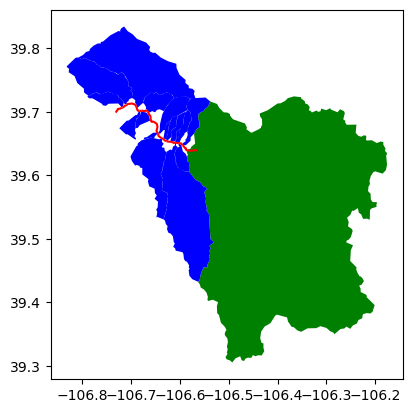

In [7]:
ax = up.plot(color="green")
trib.plot(ax=ax, color="blue")
main.plot(ax=ax, color="red")

In [9]:
path = bp_inpcache + f"inputs_{raw_id}_{dist}km_{buffer}m.csv"
if os.path.exists(path):
    inputs = pd.read_csv(path)
else:
    inputs = data.all_data_reaches(site, dist, buffer, "2015-01-01", "2022-12-31", as_df=True)
    inputs.to_csv(path, index=False)
inputs["date"] = pd.to_datetime(inputs["date"])

In [10]:
inputs

,id,id_type,lat,lon,area,water,developed,barren,forest,shrubland,...,unknown,ice_snow,elev,slope,elev_min,date,tmax,prcp,srad,vp
0,1320218,tributary,39.707065,-106.717691,8.470004e+06,0.000000,0.013346,0.00000,0.372540,0.574460,...,0.0,0.0,2577.665283,0.000143,2104.947266,2015-01-01,-4.588571,0.000000,279.294281,163.968582
1,1320218,tributary,39.707065,-106.717691,8.470004e+06,0.000000,0.013346,0.00000,0.372540,0.574460,...,0.0,0.0,2577.665283,0.000143,2104.947266,2015-01-02,-3.252857,0.000000,295.002869,165.382843
2,1320218,tributary,39.707065,-106.717691,8.470004e+06,0.000000,0.013346,0.00000,0.372540,0.574460,...,0.0,0.0,2577.665283,0.000143,2104.947266,2015-01-03,-3.497143,0.000000,252.764282,209.401443
3,1320218,tributary,39.707065,-106.717691,8.470004e+06,0.000000,0.013346,0.00000,0.372540,0.574460,...,0.0,0.0,2577.665283,0.000143,2104.947266,2015-01-04,-2.460000,0.000000,262.848572,217.355713
4,1320218,tributary,39.707065,-106.717691,8.470004e+06,0.000000,0.013346,0.00000,0.372540,0.574460,...,0.0,0.0,2577.665283,0.000143,2104.947266,2015-01-05,3.735714,0.000000,250.402847,373.067139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1318968,mainstem,39.699524,-106.731839,3.893866e+06,0.024585,0.375079,0.00021,0.047909,0.240807,...,0.0,0.0,2150.717773,0.000786,2082.747314,2022-12-27,7.541667,9.718333,196.053345,427.868317
2916,1318968,mainstem,39.699524,-106.731839,3.893866e+06,0.024585,0.375079,0.00021,0.047909,0.240807,...,0.0,0.0,2150.717773,0.000786,2082.747314,2022-12-28,4.650000,6.434999,179.028336,395.623322
2917,1318968,mainstem,39.699524,-106.731839,3.893866e+06,0.024585,0.375079,0.00021,0.047909,0.240807,...,0.0,0.0,2150.717773,0.000786,2082.747314,2022-12-29,-0.293333,1.563333,241.020004,251.536667
2918,1318968,mainstem,39.699524,-106.731839,3.893866e+06,0.024585,0.375079,0.00021,0.047909,0.240807,...,0.0,0.0,2150.717773,0.000786,2082.747314,2022-12-30,-2.310000,3.941667,199.898331,199.324997


In [11]:
subws = inputs[inputs["id_type"] != "mainstem"]

## Model No-Reach Temperature

In [12]:
nxmod = NEXT.from_pickle("coefs.pickle")

In [13]:
inp_preds = subws.groupby("id").apply(lambda x: nxmod.run(x, reset=True, use_climate=False), include_groups=False).reset_index()

In [19]:
tot_area = inp_preds.groupby("id")["area"].agg("first").sum()
tot_area

1384248904.182422

In [20]:
noreach = inp_preds.assign(tmod = lambda x: x["temp.mod"] * x["area"] / tot_area).groupby("date", as_index=False)["tmod"].agg("sum")
noreach

,date,tmod
0,2015-01-01,2.000128
1,2015-01-02,2.015137
2,2015-01-03,1.954693
3,2015-01-04,1.799638
4,2015-01-05,1.932610
...,...,...
2915,2022-12-27,2.641601
2916,2022-12-28,2.944824
2917,2022-12-29,2.803867
2918,2022-12-30,2.039196


<Axes: xlabel='date'>

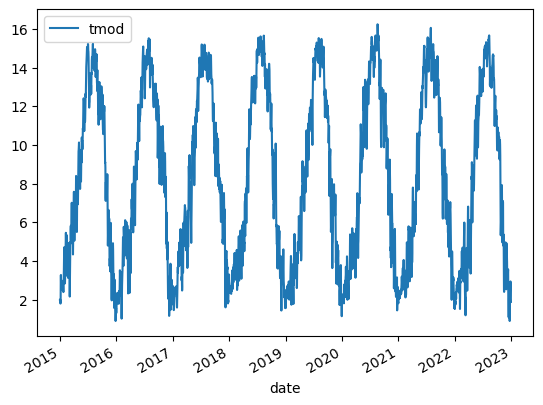

In [21]:
noreach.plot(x="date", y="tmod")

## Retrieve Observed Data and Compute Delta

In [22]:
tobs = nwis.get_dv(sites=[raw_id], start="2015-01-01", end="2022-12-31", parameterCd="00010")[0].assign(date=lambda x: pd.to_datetime(x.index.date))[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).dropna()
qobs = nwis.get_dv(sites=[raw_id], start="2015-01-01", end="2022-12-31", parameterCd="00060")[0].assign(date=lambda x: pd.to_datetime(x.index.date))[["date", "00060_Mean"]].rename(columns={"00060_Mean": "Q"}).dropna()

<Axes: xlabel='date'>

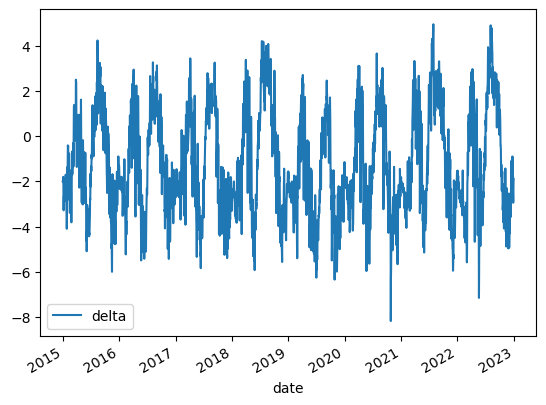

In [23]:
comb = noreach.merge(tobs, on="date").merge(qobs, on="date").assign(delta = lambda x: x["temperature"] - x["tmod"])
comb.plot(x="date", y="delta")

<Axes: xlabel='date'>

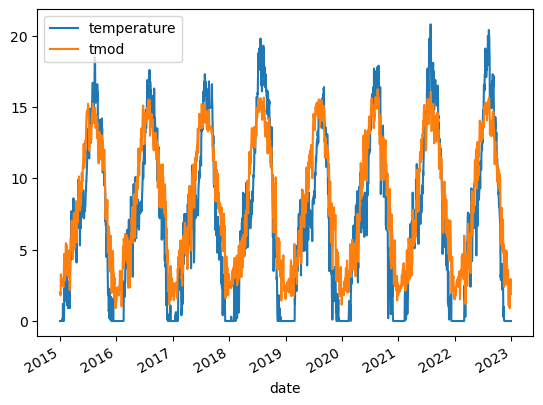

In [24]:
ax = comb.plot(x="date", y="temperature")
comb.plot(x="date", y="tmod", ax=ax)

In [25]:
rivdat = inputs[inputs["id_type"] == "mainstem"]
fulldat = comb.merge(rivdat, on="date")
fulldat

,date,tmod,temperature,Q,delta,id,id_type,lat,lon,area,...,wetland,unknown,ice_snow,elev,slope,elev_min,tmax,prcp,srad,vp
0,2015-01-01,2.000128,0.0,104.0,-2.000128,1318968,mainstem,39.699524,-106.731839,3.893866e+06,...,0.281782,0.0,0.0,2150.717773,0.000786,2082.747314,-4.670000,0.000000,248.786682,174.711670
1,2015-01-02,2.015137,0.0,109.0,-2.015137,1318968,mainstem,39.699524,-106.731839,3.893866e+06,...,0.281782,0.0,0.0,2150.717773,0.000786,2082.747314,-3.560000,0.463333,257.139984,169.581665
2,2015-01-03,1.954693,0.0,110.0,-1.954693,1318968,mainstem,39.699524,-106.731839,3.893866e+06,...,0.281782,0.0,0.0,2150.717773,0.000786,2082.747314,-2.726667,1.711667,201.885010,216.161667
3,2015-01-04,1.799638,0.0,116.0,-1.799638,1318968,mainstem,39.699524,-106.731839,3.893866e+06,...,0.281782,0.0,0.0,2150.717773,0.000786,2082.747314,-2.705000,0.740000,213.139999,228.836670
4,2015-01-05,1.932610,0.0,124.0,-1.932610,1318968,mainstem,39.699524,-106.731839,3.893866e+06,...,0.281782,0.0,0.0,2150.717773,0.000786,2082.747314,4.685000,0.000000,246.110001,376.183319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896,2022-12-27,2.641601,0.0,91.6,-2.641601,1318968,mainstem,39.699524,-106.731839,3.893866e+06,...,0.281782,0.0,0.0,2150.717773,0.000786,2082.747314,7.541667,9.718333,196.053345,427.868317
2897,2022-12-28,2.944824,0.0,89.7,-2.944824,1318968,mainstem,39.699524,-106.731839,3.893866e+06,...,0.281782,0.0,0.0,2150.717773,0.000786,2082.747314,4.650000,6.434999,179.028336,395.623322
2898,2022-12-29,2.803867,0.0,88.3,-2.803867,1318968,mainstem,39.699524,-106.731839,3.893866e+06,...,0.281782,0.0,0.0,2150.717773,0.000786,2082.747314,-0.293333,1.563333,241.020004,251.536667
2899,2022-12-30,2.039196,0.0,88.8,-2.039196,1318968,mainstem,39.699524,-106.731839,3.893866e+06,...,0.281782,0.0,0.0,2150.717773,0.000786,2082.747314,-2.310000,3.941667,199.898331,199.324997


## Fit Model

Recall:

$$
    \Delta T = (T_a-T_0)\left(1-\exp\left(-\frac{\alpha}{Q^q}\right)\right) + \frac{\beta\cdot srad + \gamma}{Q^q}
$$

Note using daily *max* air temperature here is iffy, but daymet tmin coverage is even iffier.  That may contribute to NEXT not doing any better than TE2.

In [26]:
def reachmaker(A, B, C, q):
    def delta(indat):
        return (indat["tmax"] - indat["tmod"]) * (1 - np.exp(-A / (indat["Q"] ** q))) - (B * indat["srad"] + C) / (indat["Q"] ** q)
    return delta

def reachperf(A, B, C, q, indat=fulldat):
    dmod = reachmaker(A, B, C, q)(indat)
    dobs = indat["delta"]
    return dmod.corr(dobs)

Old analysis (A, B, q, with sign differences):

Now, there is so much lumped in here that I don't know what a reasonable range for values might be, so we'll start with a very wide search and narrow it down from there.  Let's start by setting B to zero and tuning A, q.

An early conclusion is that A definitely needs to be negative, and it looks like optimal Q is about 0.5.

In A,B space, the best correlations seem to occur in a diagonal belt where A, B are negative but >-2.

The two terms seem to have a pretty solid linear tradeoff, which is interesting.  Then again, one factor being ignored here is that $A$ is roughly constant, whereas $B$ should actually be variable.  Let's try multiplying $B$ by srad.  That does marginally increase possible performance, and it changes the parameter space considerably.

Having determined a general reasonableness range, we can now start running large grid searches within that range.

- First pass: optimal A/B variable, optimal q 0.3 (R 0.65)
- Second pass: optimal q ~ 0.34 (R 0.65)
- Third pass: optimal A -1.4, optimal B -0.08 (R 0.65)
- Fourth pass: A -1, B -0.04, q 0.35 (R 0.65) - low sensitivity

A/B/q maxes out at R of 0.65, which is not great.  Let's try adding a couple more constants C, D.

Max R only nudges up to 0.66, so it seems likely we're running into a predictability limit here.  It may be that the reach is rather short.  Anyway, we can drop the extra constants.

It is not surprising that only ~40% of delta can be explained by a simple reach model here, since a lot of the delta is simple prediction error and not a physical prediction gap.  This has allowed us to show that additional complexities are not, evidently, required.

New analysis:

Optimal performance is A=7.4, B=-0.11, C=-27, q=0.35, with R of 0.66.  Note that using C here contributes very little for Eagle River, but it may be relevant to other systems that have a more pronounced constant influence (i.e. groundwater).

For Eagle River, performance is not impacted, and optimal coefficients very minimally so, by varying reach length (5-10 km) or buffer with (100-500 m).  Performance is somewhat worse for a minimum-length reach (2 km).

In [ ]:
Bmin = -0.15
Bmax = -0.08
Amin = 7
Amax = 8
Cmin = -35
Cmax = -25
qmin = 0.30
qmax = 0.40
N = 10
unrg = lambda xmin, xmax: np.arange(xmin, xmax, (xmax - xmin)/N) if xmax > xmin else np.array([xmin])
params = pd.DataFrame({"A": unrg(Amin, Amax)}).\
    merge(pd.DataFrame({"B": unrg(Bmin, Bmax)}), how="cross").\
    merge(pd.DataFrame({"C": unrg(Cmin, Cmax)}), how="cross").\
    merge(pd.DataFrame({"q": unrg(qmin, qmax)}), how="cross")
params["R"] = params.apply(lambda x: reachperf(x["A"], x["B"], x["C"], x["q"]), axis=1)
params.sort_values("R", ascending=False)
# params_array = params.pivot(index="A", columns="B", values="R")
# sns.heatmap(params_array)

,A,B,C,q,R
9676,7.9,-0.108,-28.0,0.36,0.656649
8686,7.8,-0.108,-27.0,0.36,0.656641
9686,7.9,-0.108,-27.0,0.36,0.656640
7686,7.7,-0.108,-27.0,0.36,0.656632
8676,7.8,-0.108,-28.0,0.36,0.656631
...,...,...,...,...,...
2009,7.2,-0.150,-35.0,0.39,0.645305
109,7.0,-0.143,-35.0,0.39,0.645159
19,7.0,-0.150,-34.0,0.39,0.645048
1009,7.1,-0.150,-35.0,0.39,0.644770


# Development Sample Calibrated Model Test

In case we're sticking with this equation, let's give it intelligible coefficients.

$$
    \Delta T = (T_a-T_0)\left(1-\exp\left(-\frac{\alpha}{Q^q}\right)\right) + \frac{r\cdot srad}{Q^q} + k
$$

$\alpha$: air sensitivity coefficient

$r$: radiation sensitivity coefficient

$k$: constant flux coefficient

$q$: flow sensitivity coefficient.  Note that this encapsulates both travel time and water depth.  In this relationship, roughness may partially cancel its own effect, since it makes a given discharge both deeper and slower (but more slow than deep, since it is area, not depth, that scales inversely with velocity).

1. Implement fully-automated code for the above.
    1. Delineate
    2. Pull and store data
    3. Generate no-reach predictions
    4. Calibrate model to 70%
    5. Validate on 30%
    6. Report optimal coefficients and cal/val performance
2. Summarize performance across all development watersheds

## Eagle River Retest

First, let's test the automatic version with Eagle River again.

The problem seems to be that the automatic version gets stuck in local optima (and that, dubiously).  It is also systematically incapable, apparently, of capturing the large negative delta associated with the spring snowmelt pulse, which is an upstream model error (they are evidently failing to capture that seasonal term) rather than an in-channel effect.  This is because that negative delta is driven purely by a high flow (of cold water).  One possibility would be to add a term that increases with Q, to capture such effects.

Of course, it is also possible that upstream watersheds actually don't have that snow pulse just then, since spring hits earlier down below.  This would make sense with the later positive delta.

As a simpler solution, let's remove the reliance of $k$ on $Q$ so it can become more, proportionally, impactful during high flows...

That actually works surprisingly well.  ~45% of the delta is explained, with RMSE down to 1.82 (validation), which does *not* appear to be a false optimum (i.e. it actually improves the whole way).  Crucially, it *does* capture the cold delta, relatively well.

In [2]:
raw_id = "394220106431500"
start = "2015-01-01"
end = "2022-12-31"
inp = reach.prepare_full_data("coefs.pickle", raw_id, 20, 500, start, end, bp_inpcache, True)

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (res, hist) = reach.search_reach_coefficients(inp, (-1, 1), (-1, 1), (-1, 1), (0, 1), log=True, tolerance=0.0001)

In [4]:
res

{'alpha': 1.75,
 'r': 0.038360595703125,
 'k': -4.0,
 'q': 0.41259765625,
 'R': 0.6828572490958309,
 'bias': -0.1170694138602591,
 'rmse': 1.81960487995814}

In [5]:
hist

,alpha,r,k,q,R,bias,rmse,score
0,1.00,0.000000,-1.000,0.500000,0.593051,0.709221,2.090177,2.090177
1,0.50,0.000000,-2.000,0.250000,0.549732,0.065373,1.893929,1.893929
2,1.00,0.125000,-2.500,0.750000,0.440546,0.118572,2.020058,2.020058
3,1.00,0.062500,-3.250,0.500000,0.607925,0.096723,1.788051,1.788051
4,1.00,0.062500,-1.750,0.687500,0.531141,0.370237,2.038379,2.038379
5,1.00,0.218750,-3.250,0.718750,0.415413,0.124241,2.021825,2.021825
6,1.00,0.062500,-4.000,0.421875,0.633164,0.339068,1.741461,1.741461
7,1.00,0.062500,-4.000,0.421875,0.633164,0.339068,1.741461,1.741461
8,2.00,0.140625,-4.000,0.570312,0.569766,0.411182,1.889205,1.889205
9,2.00,0.117188,-4.000,0.570312,0.584449,0.018811,1.794343,1.794343


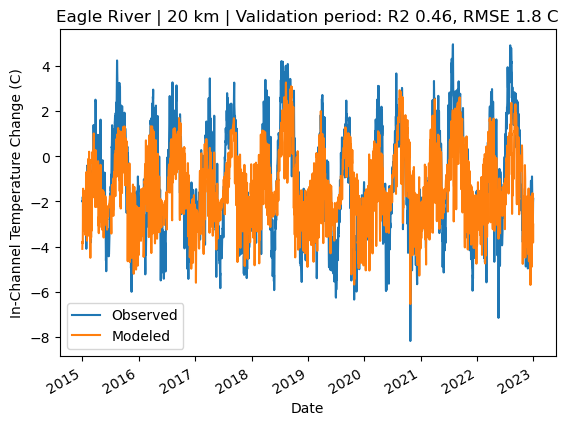

In [27]:
for pv in ["R", "bias", "rmse"]:
    res.pop(pv, None)
mod = reach.monoreach_maker(**res)
# mod = reach.monoreach_maker(alpha=2, r=0.25, k=-100, q=0.6)
inp["delta_mod"] = mod(inp)
ax = inp.plot(x="date", y="delta", label="Observed")
inp.plot(x="date", y="delta_mod", ax=ax, label="Modeled")
ax.set_xlabel("Date")
ax.set_ylabel("In-Channel Temperature Change (C)")
_ = ax.set_title("Eagle River | 20 km | Validation period: R2 0.46, RMSE 1.8 C")

<Axes: xlabel='date'>

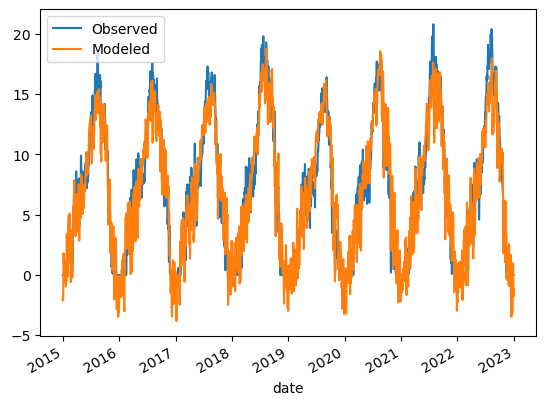

In [8]:
inp["tmod_delta"] = inp["tmod"] + inp["delta_mod"]
ax = inp.plot(x="date", y="temperature", label="Observed")
inp.plot(x="date", y="tmod_delta", ax=ax, label="Modeled")

## Data Prep

Okay, how do we do this for a large sample?

1. List out the sample.
2. For each item in the sample, set a random reach length (1-100 km) and buffer width (100-1000 m).
3. If retrieval crashes, try again with a longer, and a shorter, length.  If that all fails, skip it.
4. Fit models, store results.

See `reach_proc.py`.  This was moved to a Python script to allow running in the background.

## Coefficient Analysis

In [31]:
rdfile = bp + "reach_coefs.csv"
rdata = pd.read_csv(rdfile, dtype={"id": "str"}).drop(columns="unknown")

So far (80 of ~900 complete):

- Median R 0.55, small bias, and RMSE ~2.1 C.  (Note this suggests the output of a perfectly-fitted reach model would have roughly the same performance as a lumped model.)
- alpha is usually positive and close to 1.  It has not exceeded $\pm$ 4.
- r is usually ~0-0.1, but sometimes negative and sometimes of much larger magnitude.
- k is usually negative and on the order of -1.
- q is always positive and usually 0.3-1.5.

In [35]:
len(rdata["id"]) == len(rdata["id"].unique())

True

In [36]:
rdata.columns

Index(['id', 'tmod', 'temperature', 'Q', 'delta', 'lat', 'lon', 'area',
       'water', 'developed', 'barren', 'forest', 'shrubland', 'herbaceous',
       'cultivated', 'wetland', 'ice_snow', 'elev', 'slope', 'elev_min',
       'tmax', 'prcp', 'srad', 'vp', 'length', 'buffer', 'alpha', 'r', 'k',
       'q', 'R', 'bias', 'rmse'],
      dtype='object')

In [37]:
rdata.loc[:,"length":"rmse"].describe()

,length,buffer,alpha,r,k,q,R,bias,rmse
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,27.000000,29.000000,29.000000
mean,17.586207,493.103448,0.761584,2.063458,-0.819775,2.080969,0.464250,inf,inf
std,21.559746,241.913554,1.333852,8.209401,4.179556,5.728837,0.270857,NaN,NaN
min,1.000000,100.000000,-3.875000,-0.296875,-6.518566,0.000000,-0.202233,-7.598505,1.147216
25%,2.000000,400.000000,0.500000,0.000000,-2.774849,0.317688,0.329542,-0.530537,1.780227
50%,5.000000,500.000000,1.000000,0.011719,-1.640625,0.603516,0.551116,-0.032717,2.093846
75%,30.000000,700.000000,1.000000,0.102539,-0.474996,1.250000,0.637703,0.233168,2.581012
max,89.000000,900.000000,4.000000,43.343750,13.178101,31.272705,0.849823,inf,inf


In [38]:
c = (rdata.corr()**2).loc["lat":"buffer", "alpha":"q"]
c

,alpha,r,k,q
lat,0.000872,0.068110,0.001047,0.003160
lon,0.131309,0.038114,0.030213,0.002458
area,0.023690,0.034223,0.086711,0.021455
water,0.002176,0.007285,0.000101,0.010010
developed,0.172151,0.000265,0.018966,0.024114
barren,0.028158,0.011984,0.027764,0.012492
forest,0.025755,0.025146,0.005033,0.019764
shrubland,0.029215,0.075194,0.001384,0.016257
herbaceous,0.019463,0.013790,0.013816,0.012740
cultivated,0.000265,0.000423,0.002487,0.005580


In [39]:
c.sum()

alpha    0.712604
r        0.459013
k        0.408909
q        0.363080
dtype: float64

Linearly and assuming independence, the available variables can explain 80% of alpha, 50% of r, 40% of k, and 40% of q.  Specific correlations of note:

- alpha (air-T decay rate): Developed (24%), longitude (13%), buffer width (11%), assorted land covers (up to 5%).  Interestingly, length is not terribly important.
- r (solar influence): shrubland (9%), latitude/longitude (8% each), vp (5%), forest (4%), area (3%), misc others.  Here again, length is relatively unimportant.  I'm also surprised to see that forest cover is relatively unimportant, but it's possible that shrubland is most commonly associated with low shade.  It's very interesting how decisive lat/lon are; latitude, longitude and shrubland together account for about half of the explained variance.
- k (other fluxes): area (10%), longitude (7%), vapor pressure (6%), length (5%), buffer (4%), misc land covers (up to 2.5%).  The biggest factors are watershed size and location, which could have to do with groundwater influence, but we also see humidity playing a key role, which could have to do with some combination of groundwater (generally wet climate) and evaporation.
- q (discharge sensitivity): vp (7%), tmax (5%), length (4%), wetland (4%), area (3%), various land covers etc.  That's bizarre, but we shouldn't actually expect q to be predictable, since it's really driven by channel morphology.

One thing we should investigate, before attempting to predict coefficients, is the sensitivity of performance to each coefficient.  If $q$ is hard to predict, we're better off if we can just assume some default value.  To do that, we can load the cached data and optimal coefficients, then randomly perturb each coefficient (one at a time) and plot out performance impact by perturbation value (a good metric would probably be percent increase in RMSE).

In [40]:
c.sort_values("alpha", ascending=False)[:10]

,alpha,r,k,q
developed,0.172151,0.000265,0.018966,0.024114
lon,0.131309,0.038114,0.030213,0.002458
buffer,0.115480,0.033721,0.035880,0.004300
wetland,0.041874,0.000597,0.000668,0.028557
ice_snow,0.035659,0.003574,0.001108,0.004257
shrubland,0.029215,0.075194,0.001384,0.016257
barren,0.028158,0.011984,0.027764,0.012492
forest,0.025755,0.025146,0.005033,0.019764
area,0.023690,0.034223,0.086711,0.021455
srad,0.023155,0.020153,0.001163,0.000831


# Running All Reaches

In [1]:
import reach_proc

In [ ]:
reach_proc.main()